In [18]:
# set up

from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist
from IPython.display import Image
PATH = "/Users/Song/Desktop/Tensorflow codes/Pictures/"

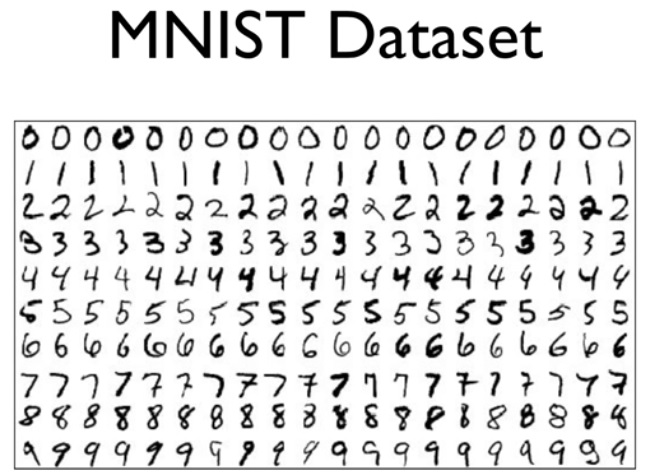

In [19]:
# minist dataset

Image(filename = PATH + "33.jpg")

# http://yann.lecun.com/exdb/mnist

# train-images-idx3-ubyte.gz: training images (9912422 bytes)
# train-lables-idx1-ubyte.gz: training labels (28881 bytes)
# t10k-images-idx3-ubyte.gz: test images (1648877 byte)
# t10k-labels-idxl-ubytes.gz: test labels (4542 bytes)  

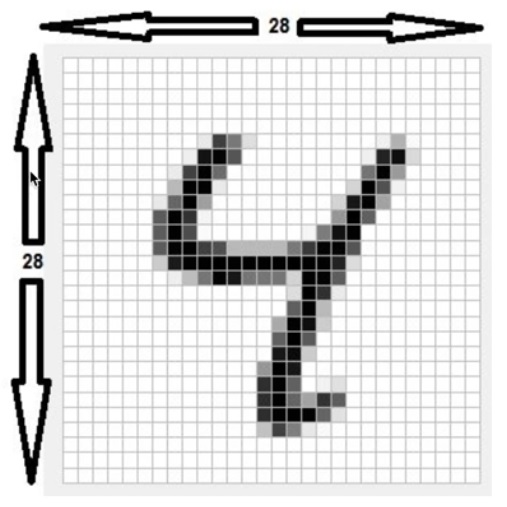

In [20]:
Image(filename = PATH + "34.jpg")

# 28 x 28 = 784 image
# 0 ~ 9 digit recognition (10 classes)

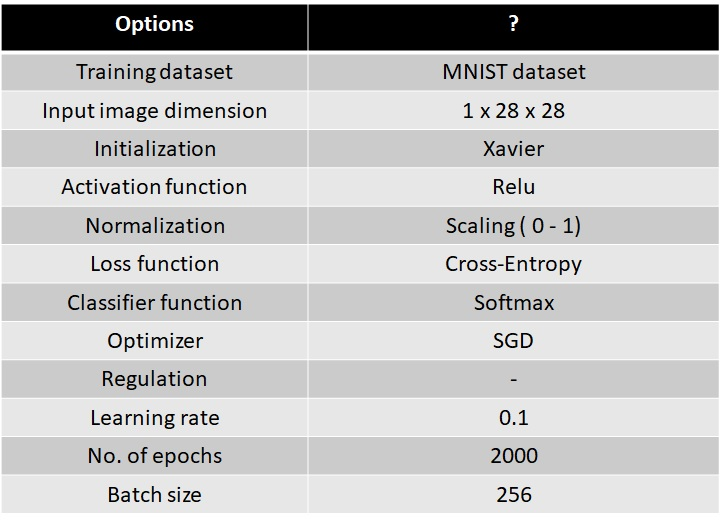

In [21]:
# options for the proposed NN

Image(filename = PATH + "38.jpg")

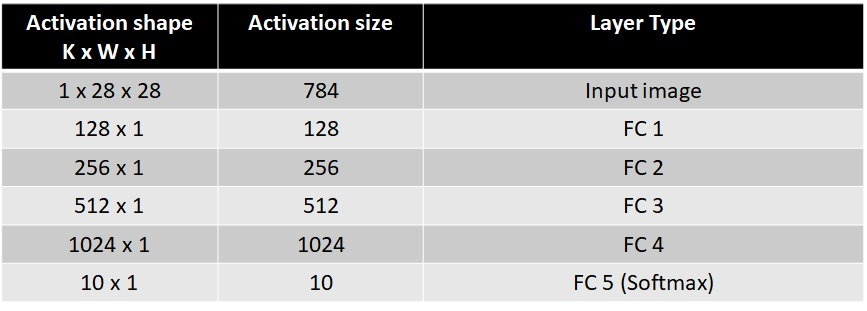

In [22]:
# architecture for the proposed NN

Image(filename = PATH + "40.jpg")

In [23]:
# prepare dataset

# MNIST dataset parameters

num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28 X 28 = 784)

# import and load MNIST data, split between and test datasets

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert pixel values to float32

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# normalize image pixcel values from [0, 255] to [0, 1]

x_train, x_test = x_train / 255., x_test / 255.

# check the shape of MNIST data

print('MNIST Dataset Shapes:')
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_test: ' + str(x_test.shape))
print('y_test: ' + str(y_test.shape))

MNIST Dataset Shapes:
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [24]:
# training parameters

learning_rate = 0.1
training_epochs = 2000
batch_size = 256
display_step = 100

In [25]:
# network parameters

n_hidden_1 = 128 # 1st hidden layer number of neurons
n_hidden_2 = 256 # 2nd hidden layer number of neurons
n_hidden_3 = 512 # 3nd hidden layer number of neurons
n_hidden_4 = 1024 # 2nd hidden layer number of neurons

In [26]:
# flatten image pixels to 1-D vector of 784 features (28 x 28)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

In [27]:
# use tf.data API to shuffle and batch data

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [28]:
# create MNIST architecture

class NeuralNet(Model):
    
    # set layers
    
    def __init__(self):
        
        super(NeuralNet, self).__init__()
        
        # first fully-connected hidden layer
        self.fc1 = layers.Dense(units = n_hidden_1, activation=tf.nn.relu)
        
        # second-connected hidden layer
        self.fc2 = layers.Dense(units = n_hidden_2, activation=tf.nn.relu)
        
        # first fully-connected hidden layer
        self.fc3 = layers.Dense(units = n_hidden_3, activation=tf.nn.relu)
        
        # second-connected hidden layer
        self.fc4 = layers.Dense(units = n_hidden_4, activation=tf.nn.relu)
        
        # fully-connecter output layer
        self.out = layers.Dense(units = num_classes)

    # set forward pass
    
    def call(self, x, is_training = False):
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)        
        x = self.out(x)
        
        if not is_training:
            
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
            
        return x

In [29]:
# build neural network model

neural_net = NeuralNet()

In [30]:
# initialize variables with Xavier uniform

shape = (num_features, num_classes)
initializer = tf.initializers.GlorotUniform()
trainable_variables = tf.Variable(initializer(shape = shape))

In [31]:
# Cross-Entropy loss
# note that this will apply 'softmax' to the logits

def cross_entropy_loss(x, y):
    
    # convert labels to int 64 for tf cross-entropy function
    y = tf.cast(y, tf.int64)
    
    # apply softmax to logits and compute cross-entropy
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = x)
    
    # average loss across the batch
    
    return tf.reduce_mean(loss)

In [32]:
# accuracy metric

def accuracy(y_pred, y_true):
    
    # predicted class is the index of highest score in prediction vector (i.e. argmax)
    
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [33]:
# Stochastic gradient descent optimizer

optimizer = tf.keras.optimizers.SGD(learning_rate)

# set up an optimization (forward propagation and backpropagation) process 

def run_optimization(x, y):
    
    # wrap computation inside a GradientTape for automatic differentiation
    
    with tf.GradientTape() as g:
        
        # forward pass
        pred = neural_net(x, is_training = True)
        
        # compute loss
        loss = cross_entropy_loss(pred, y)
        
    # variables to update, i.e. trainable variables
    trainable_variables = neural_net.trainable_variables

    # compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # apply the gradients to update 𝜃 and 𝜃_0  
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [34]:
# run training for the given number of steps

for step, (batch_x, batch_y) in enumerate(train_data.take(training_epochs), 1):
    
    # run the optimization process to update 𝜃 and 𝜃_0 values
    
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training = True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
        
# test the proposed model on validation set

pred = neural_net(x_test, is_training = False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

step: 100, loss: 0.666218, accuracy: 0.792969
step: 200, loss: 0.310464, accuracy: 0.917969
step: 300, loss: 0.279516, accuracy: 0.910156
step: 400, loss: 0.214339, accuracy: 0.941406
step: 500, loss: 0.118053, accuracy: 0.968750
step: 600, loss: 0.133927, accuracy: 0.964844
step: 700, loss: 0.066284, accuracy: 0.984375
step: 800, loss: 0.090650, accuracy: 0.968750
step: 900, loss: 0.077056, accuracy: 0.964844
step: 1000, loss: 0.078136, accuracy: 0.976562
step: 1100, loss: 0.080908, accuracy: 0.984375
step: 1200, loss: 0.074432, accuracy: 0.980469
step: 1300, loss: 0.075412, accuracy: 0.976562
step: 1400, loss: 0.066231, accuracy: 0.984375
step: 1500, loss: 0.091546, accuracy: 0.984375
step: 1600, loss: 0.045704, accuracy: 0.992188
step: 1700, loss: 0.036278, accuracy: 0.988281
step: 1800, loss: 0.057438, accuracy: 0.984375
step: 1900, loss: 0.030412, accuracy: 0.992188
step: 2000, loss: 0.047300, accuracy: 0.992188
Test Accuracy: 0.971100
